In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.spatial.distance import euclidean as euc
import numpy as np
from sklearn.datasets import make_classification
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report, roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from ipywidgets import interactive, FloatSlider
np.random.seed(0)
import pickle
from sklearn.model_selection import GridSearchCV
import dtale
from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from nba_all_modeling_functions import nba_log_regression, nba_knn, nba_random_forest, nba_svc

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 60)
%matplotlib inline

## Pickling in "all_data_df"

In [2]:
with open("all_data.pickle", "rb") as to_read:
    all_data_df = pickle.load(to_read)

In [3]:
all_data_df.to_csv("Main df.csv")

In [4]:
all_data_df.dtypes

Year                       int64
Player                    object
Pos                       object
Age                      float64
Tm                        object
G                        float64
GS                       float64
MP                       float64
PER                      float64
TS%                      float64
3PAr                     float64
FTr                      float64
ORB%                     float64
DRB%                     float64
TRB%                     float64
AST%                     float64
STL%                     float64
BLK%                     float64
TOV%                     float64
USG%                     float64
OWS                      float64
DWS                      float64
WS                       float64
WS/48                    float64
OBPM                     float64
DBPM                     float64
BPM                      float64
VORP                     float64
FG                       float64
FGA                      float64
FG%       

## First attempt at logistic regression and KNN

Score on test set (5-fold validation): 0.94585831239771

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      1654
           1       0.65      0.39      0.49       104

    accuracy                           0.95      1758
   macro avg       0.81      0.69      0.73      1758
weighted avg       0.94      0.95      0.95      1758




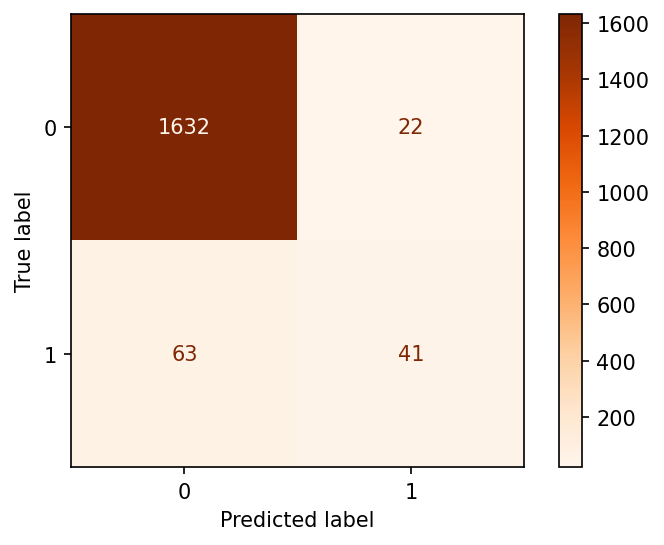

In [6]:
score, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS", "AST", "PER"], "All-Star next season?", print_all=True)

In [63]:
# Using features I am suspecting will have high correlation
features = ["PTS", "AST", "PER"]
X = all_data_df[features]
y = all_data_df["All-Star next season?"]

# Test-train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=10)

# Scaling training set (for now) and testing set (for later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [126]:
print(classification_report(y_val, logr_val_predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1253
           1       0.80      0.59      0.68        66

    accuracy                           0.97      1319
   macro avg       0.89      0.79      0.83      1319
weighted avg       0.97      0.97      0.97      1319



              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1253
           1       0.80      0.59      0.68        66

    accuracy                           0.97      1319
   macro avg       0.89      0.79      0.83      1319
weighted avg       0.97      0.97      0.97      1319



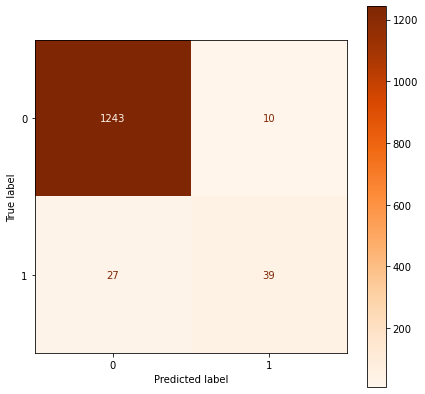

In [129]:
# First logistic regression function
logr = LogisticRegression()
logr.fit(X_train_scaled, y_train)
logr_val_predictions = logr.predict(X_val_scaled)
logr_tn, logr_fp, logr_fn, logr_tp = confusion_matrix(y_val, logr_val_predictions).ravel()
logr_prob_predictions = logr.predict_proba(X_val_scaled)
logr_prob_dict = dict(zip(list(X_val.index), list(logr_prob_predictions)))

years_list = [year.split(", ")[1] for year in logr_prob_dict.keys()]
years_list = list(set(years_list))
years_list.sort()
print(classification_report(y_val, logr_val_predictions))

# Plotting in a confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(logr, X_val_scaled, y_val, ax=ax, cmap="Oranges")
#plt.savefig("First log confusion matrix (PTS, AST, PER)");

#for year in years_list:
    #eligible_players = [[player, list(chance)[1]] for player, chance in prob_dict.items() if player.split(", ")[1] == year]
    #top_24 = [[player, chance] for player, chance in sorted(eligible_players, key=lambda item: item[1], reverse=True)][:24]
    #print("Top 24 most likely All-Stars in {}: {}".format(year, (", ".join([all_star[0].split(", ")[0] for all_star in #top_24]))))
    #print("***********\nNext season...\n***********")
    
    
#top_20 = [[player, chance] for player, chance in sorted(prob_dict.items(), key=lambda item: item[1][1], reverse=True)][:20]
#top_20

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1325
           1       0.63      0.40      0.48        81

    accuracy                           0.95      1406
   macro avg       0.80      0.69      0.73      1406
weighted avg       0.94      0.95      0.95      1406



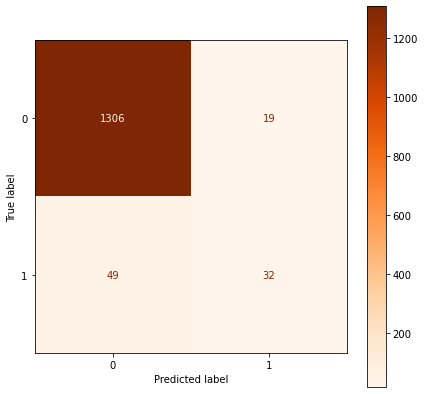

In [69]:
# Trying KNN
nn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
nn.fit(X_train_scaled, y_train)
knn_predictions = nn.predict(X_val_scaled)
knn_prob_predictions = nn.predict_proba(X_val_scaled)
knn_tn, knn_fp, knn_fn, knn_tp = confusion_matrix(y_val, knn_predictions).ravel()

print(classification_report(y_val, knn_predictions))

# Plotting in a confusion matrix
fig, ax = plt.subplots(figsize=(7, 7));
plot_confusion_matrix(nn, X_val_scaled, y_val, ax=ax, cmap="Oranges");
#plt.savefig("First KNN confusion matrix (PTS, AST, PER)")

## Plotting ROC-AUC

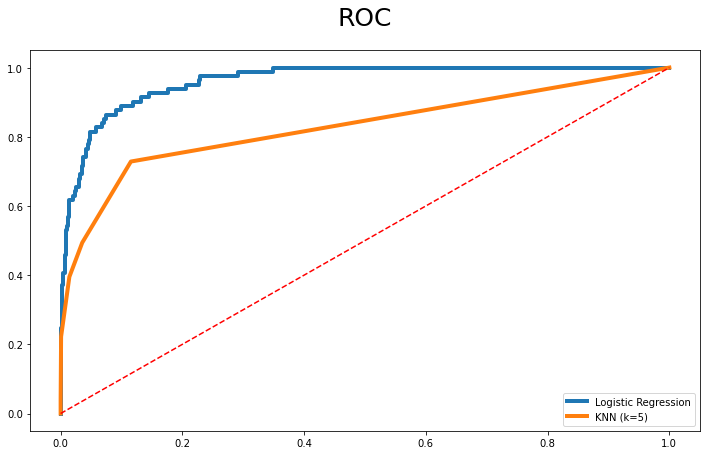

In [74]:
# Logistic regression
logr_pos_preds = logr_prob_predictions[:, 1]
logr_fpr, logr_tpr, logr_threshold = roc_curve(y_val, logr_pos_preds)
roc_auc = auc(logr_fpr, logr_tpr)

# KNN
knn_pos_preds = knn_prob_predictions[:, 1]
knn_fpr, knn_tpr, knn_threshold = roc_curve(y_val, knn_pos_preds)
roc_auc = auc(knn_fpr, knn_tpr)

fig, ax = plt.subplots(figsize=(12,7), sharex=True, sharey=True)
ax.set_title('ROC', fontdict={"fontsize": 25}, y=1.05)
ax.plot(logr_fpr, logr_tpr, label="Logistic Regression", lw=4)
ax.plot(knn_fpr, knn_tpr, label="KNN (k=5)", lw=4)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--');

## Next try

In [7]:
all_data_df.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,All-Star?,Selection process,All-Star next season?,TV market size
"Player, year",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"A.C. Green, 2000",2000,A.C. Green,PF,36.0,LAL,82.0,82.0,1929.0,11.2,0.482,0.010,0.245,9.0,17.9,13.5,5.9,1.4,0.7,11.0,11.0,1.7,3.3,5.0,0.124,-2.0,1.8,-0.2,0.9,173.0,387.0,0.447,1.0,4.0,0.250,172.0,383.0,0.449,0.448,66.0,95.0,0.695,160.0,326.0,486.0,80.0,53.0,18.0,53.0,127.0,413.0,0,N/a,0,5354150.0
"A.C. Green, 2001",2001,A.C. Green,PF,37.0,MIA,82.0,1.0,1411.0,11.2,0.492,0.019,0.343,9.0,17.3,13.2,4.8,1.2,0.4,10.8,14.4,1.1,2.1,3.2,0.110,-3.2,0.2,-3.0,-0.3,144.0,324.0,0.444,0.0,6.0,0.000,144.0,318.0,0.453,0.444,79.0,111.0,0.712,107.0,206.0,313.0,39.0,30.0,8.0,45.0,119.0,367.0,0,N/a,0,1468630.0
"A.J. Bramlett, 2000",2000,A.J. Bramlett,C,23.0,CLE,8.0,0.0,61.0,-0.4,0.190,0.000,0.000,21.7,18.5,20.1,0.0,0.8,0.0,12.5,17.1,-0.2,0.1,-0.2,-0.129,-10.5,-6.3,-16.8,-0.2,4.0,21.0,0.190,0.0,0.0,NaN,4.0,21.0,0.190,0.190,0.0,0.0,NaN,12.0,10.0,22.0,0.0,1.0,0.0,3.0,13.0,8.0,0,N/a,0,1488270.0
"A.J. Guyton, 2001",2001,A.J. Guyton,PG,22.0,CHI,33.0,8.0,630.0,10.3,0.495,0.359,0.094,1.8,5.1,3.4,18.1,0.8,0.6,10.7,16.5,0.4,-0.1,0.3,0.020,-1.5,-4.4,-5.9,-0.6,78.0,192.0,0.406,27.0,69.0,0.391,51.0,123.0,0.415,0.477,15.0,18.0,0.833,10.0,26.0,36.0,64.0,9.0,5.0,24.0,35.0,198.0,0,N/a,0,3244850.0
"A.J. Guyton, 2002",2002,A.J. Guyton,PG,23.0,CHI,45.0,6.0,607.0,11.8,0.477,0.504,0.111,2.3,6.3,4.2,23.6,0.9,0.9,12.6,22.2,0.0,0.0,0.1,0.006,-0.3,-4.4,-4.7,-0.4,88.0,244.0,0.361,46.0,123.0,0.374,42.0,121.0,0.347,0.455,22.0,27.0,0.815,12.0,32.0,44.0,81.0,10.0,7.0,37.0,23.0,244.0,0,N/a,0,3244850.0


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1325
           1       0.85      0.35      0.49        81

    accuracy                           0.96      1406
   macro avg       0.90      0.67      0.73      1406
weighted avg       0.95      0.96      0.95      1406



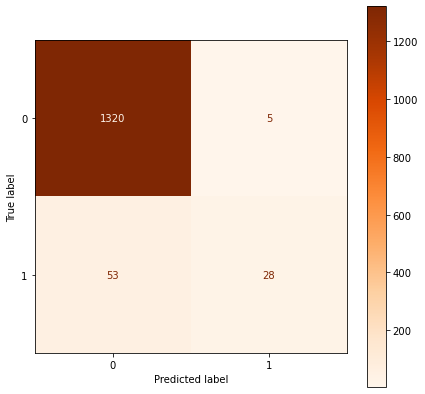

In [20]:
# Second attempt at KNN (adding "MP" and "Age")
# Tried some different k values here
features = ["PTS", "AST", "PER", "MP", "Age"]
X = all_data_df[features]
y = all_data_df["All-Star next season?"]

# Test-train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=10)

# Scaling training set (for now) and validation set (for later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Instantiating and fitting
nn = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)
nn.fit(X_train_scaled, y_train)
knn_predictions = nn.predict(X_val_scaled)
knn_prob_predictions = nn.predict_proba(X_val_scaled)
knn_tn, knn_fp, knn_fn, knn_tp = confusion_matrix(y_val, knn_predictions).ravel()

# Performance
print(classification_report(y_val, knn_predictions))
fig, ax = plt.subplots(figsize=(7, 7));
plot_confusion_matrix(nn, X_val_scaled, y_val, ax=ax, cmap="Oranges");

In [22]:
# Searching for optimal k
ks = range(1, 50)
for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_scaled, y_train)
    val_preds = knn.predict(X_val_scaled)
    #print(f' Score with k value of {k}: {accuracy_score(y_val, val_preds)}')

## Next try

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1325
           1       0.85      0.35      0.49        81

    accuracy                           0.96      1406
   macro avg       0.90      0.67      0.73      1406
weighted avg       0.95      0.96      0.95      1406



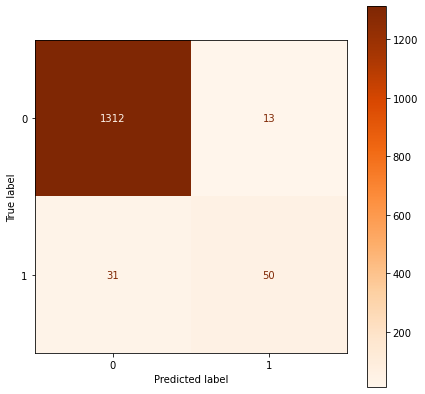

In [76]:
# Third attempt (adding "All-Star?")
features = ["PTS", "AST", "PER", "MP", "Age", "All-Star?"]
X = all_data_df[features]
y = all_data_df["All-Star next season?"]

# Test-train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=10)

# Scaling training set (for now) and validation set (for later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Instantiating and fitting
logr = LogisticRegression()
logr.fit(X_train_scaled, y_train)
logr_val_predictions = logr.predict(X_val_scaled)
logr_tn, logr_fp, logr_fn, logr_tp = confusion_matrix(y_val, logr_val_predictions).ravel()
logr_prob_predictions = logr.predict_proba(X_val_scaled)

# Performance
print(classification_report(y_val, predictions))
fig, ax = plt.subplots(figsize=(7, 7));
plot_confusion_matrix(logr, X_val_scaled, y_val, ax=ax, cmap="Oranges");

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1325
           1       0.85      0.35      0.49        81

    accuracy                           0.96      1406
   macro avg       0.90      0.67      0.73      1406
weighted avg       0.95      0.96      0.95      1406



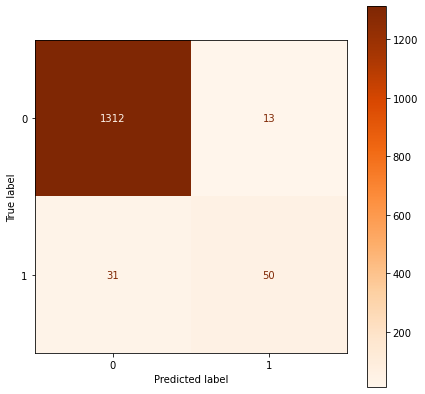

In [77]:
# Instantiating and fitting KNN
nn = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)
nn.fit(X_train_scaled, y_train)
knn_predictions = nn.predict(X_val_scaled)
knn_prob_predictions = nn.predict_proba(X_val_scaled)
knn_tn, knn_fp, knn_fn, knn_tp = confusion_matrix(y_val, knn_predictions).ravel()

# Performance
print(classification_report(y_val, predictions))
fig, ax = plt.subplots(figsize=(7, 7));
plot_confusion_matrix(logr, X_val_scaled, y_val, ax=ax, cmap="Oranges");

## Trying random forest for the first time

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1325
           1       0.00      0.00      0.00        81

    accuracy                           0.94      1406
   macro avg       0.47      0.50      0.48      1406
weighted avg       0.89      0.94      0.91      1406

[0.17056104 0.1399955  0.22869618 0.15553005 0.10673243 0.19848481]


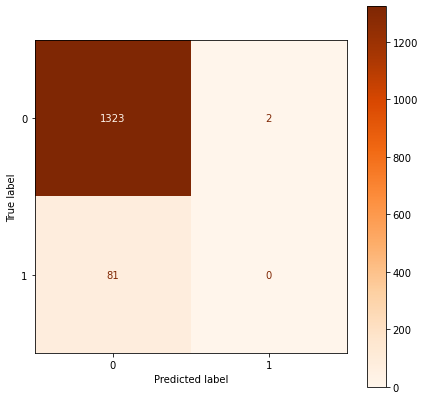

In [79]:
# Instantiating and fitting
ran_for = RandomForestClassifier()
ran_for.fit(X_train_scaled, y_train)
ran_for_predictions = ran_for.predict(X_val)
ran_for_prob_predictions = ran_for.predict_proba(X_val_scaled)
ran_for_tn, ran_for_fp, ran_for_fn, ran_for_tp = confusion_matrix(y_val, ran_for_predictions).ravel()

# Performance
print(classification_report(y_val, ran_for_predictions))
fig, ax = plt.subplots(figsize=(7, 7));
plot_confusion_matrix(ran_for, X_val, y_val, ax=ax, cmap="Oranges");
print(ran_for.feature_importances_)

## First Naive Bayes

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1325
           1       0.00      0.00      0.00        81

    accuracy                           0.94      1406
   macro avg       0.47      0.50      0.49      1406
weighted avg       0.89      0.94      0.91      1406



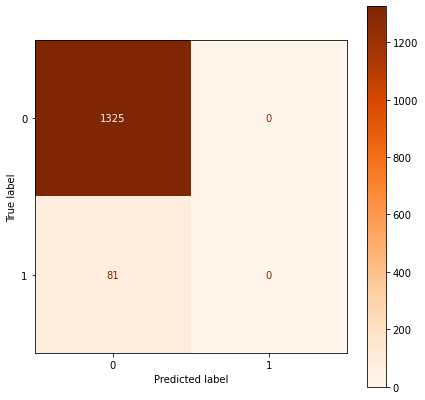

In [86]:
# Naive Bayes (Gaussian)
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
gnb_predictions = gnb.predict(X_val)
gnb_prob_predictions = gnb.predict_proba(X_val_scaled)
gnb_tn, gnb_fp, gnb_fn, gnb_tp = confusion_matrix(y_val, gnb_predictions).ravel()

# Performance
print(classification_report(y_val, gnb_predictions))
fig, ax = plt.subplots(figsize=(7, 7));
plot_confusion_matrix(gnb, X_val, y_val, ax=ax, cmap="Oranges");

## Second ROC curve

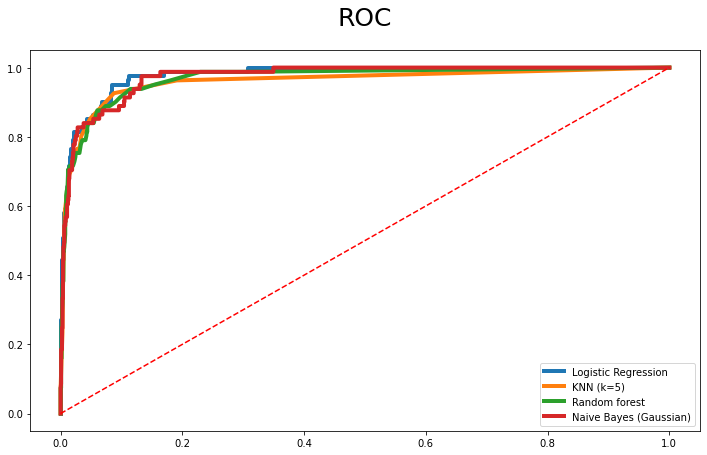

In [87]:
# Logistic regression
logr_pos_preds = logr_prob_predictions[:, 1]
logr_fpr, logr_tpr, logr_threshold = roc_curve(y_val, logr_pos_preds)
logr_roc_auc = auc(logr_fpr, logr_tpr)

# KNN
knn_pos_preds = knn_prob_predictions[:, 1]
knn_fpr, knn_tpr, knn_threshold = roc_curve(y_val, knn_pos_preds)
knn_roc_auc = auc(knn_fpr, knn_tpr)

# Random forest
ran_for_pos_preds = ran_for_prob_predictions[:, 1]
ran_for_fpr, ran_for_tpr, ran_for_threshold = roc_curve(y_val, ran_for_pos_preds)
ran_for_roc_auc = auc(ran_for_fpr, ran_for_tpr)

# Naive Bayes
gnb_pos_preds = gnb_prob_predictions[:, 1]
gnb_fpr, gnb_tpr, gnb_threshold = roc_curve(y_val, gnb_pos_preds)
gnb_roc_auc = auc(gnb_fpr, gnb_tpr)

fig, ax = plt.subplots(figsize=(12,7), sharex=True, sharey=True)
ax.set_title('ROC', fontdict={"fontsize": 25}, y=1.05)
ax.plot(logr_fpr, logr_tpr, label="Logistic Regression", lw=4)
ax.plot(knn_fpr, knn_tpr, label="KNN (k=5)", lw=4)
ax.plot(ran_for_fpr, ran_for_tpr, label="Random forest", lw=4)
ax.plot(gnb_fpr, gnb_tpr, label="Naive Bayes (Gaussian)", lw=4)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--');

## Next try (after filling TOR and VAN "TV market size")

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1253
           1       0.79      0.58      0.67        66

    accuracy                           0.97      1319
   macro avg       0.88      0.78      0.83      1319
weighted avg       0.97      0.97      0.97      1319



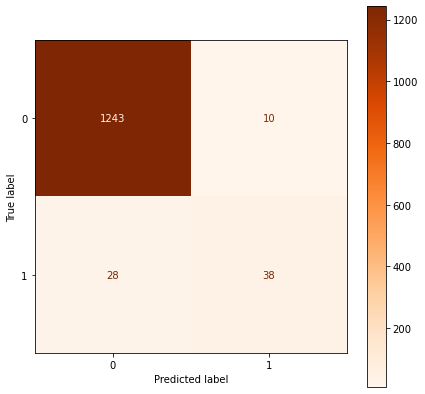

In [20]:
# Fourth attempt (adding "TV market size?")
features = ["PTS", "AST", "PER", "MP", "Age", "All-Star?", "TV market size"]
X = all_data_df[features]
y = all_data_df["All-Star next season?"]

# Test-train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=10)

# Scaling training set (for now) and validation set (for later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Instantiating and fitting
logr = LogisticRegression()
logr.fit(X_train_scaled, y_train)
logr_val_predictions = logr.predict(X_val_scaled)
logr_tn, logr_fp, logr_fn, logr_tp = confusion_matrix(y_val, logr_val_predictions).ravel()
logr_prob_predictions = logr.predict_proba(X_val_scaled)

# Performance
print(classification_report(y_val, logr_val_predictions))
fig, ax = plt.subplots(figsize=(7, 7));
plot_confusion_matrix(logr, X_val_scaled, y_val, ax=ax, cmap="Oranges");

## New attempt (after adding per game states)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1253
           1       0.80      0.59      0.68        66

    accuracy                           0.97      1319
   macro avg       0.89      0.79      0.83      1319
weighted avg       0.97      0.97      0.97      1319



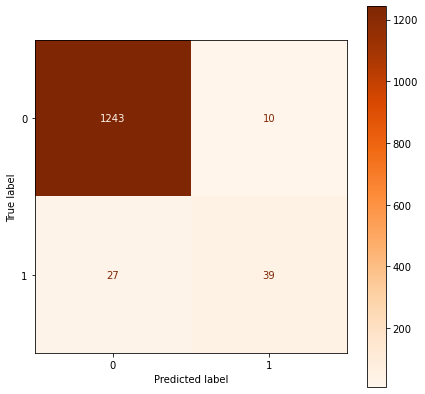

In [121]:
# Fourth attempt (adding "TV market size?")
features = ["PTS/game", "AST/game", "PER", "MP/game", "Age", "All-Star?", "TV market size"]
X = all_data_df[features]
y = all_data_df["All-Star next season?"]

# Test-train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=10)

# Scaling training set (for now) and validation set (for later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Instantiating and fitting
logr = LogisticRegression()
logr.fit(X_train_scaled, y_train)
logr_val_predictions = logr.predict(X_val_scaled)
logr_tn, logr_fp, logr_fn, logr_tp = confusion_matrix(y_val, logr_val_predictions).ravel()
logr_prob_predictions = logr.predict_proba(X_val_scaled)

# Performance
print(classification_report(y_val, logr_val_predictions))
fig, ax = plt.subplots(figsize=(7, 7));
plot_confusion_matrix(logr, X_val_scaled, y_val, ax=ax, cmap="Oranges");

In [21]:
all_data_df.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,...,PTS/game average,PTS/game relative,ORB/game,ORB/game average,ORB/game relative,DRB/game,DRB/game average,DRB/game relative,TRB/game,TRB/game average,TRB/game relative,STL/game,STL/game average,STL/game relative,BLK/game,BLK/game average,BLK/game relative,MP/game,MP/game average,MP/game relative,3P/game,3P/game average,3P/game relative,FT/game,FT/game average,FT/game relative,FTA/game,FTA/game average,FTA/game relative,Years from prime
"Player, year",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"A.C. Green, 2000",2000,A.C. Green,PF,36.0,LAL,82.0,82.0,1929.0,11.2,0.482,0.010,0.245,9.0,17.9,13.5,5.9,1.4,0.7,11.0,11.0,1.7,3.3,5.0,0.124,-2.0,1.8,-0.2,0.9,173.0,387.0,...,8.2,-0.6,2.0,1.1,1.1,4.0,2.6,0.8,5.9,3.7,0.9,0.6,0.7,-0.2,0.2,0.4,-0.4,23.5,20.9,0.3,0.0,0.4,-0.8,0.8,1.6,-0.6,1.2,2.1,-0.5,-9.0
"A.C. Green, 2001",2001,A.C. Green,PF,37.0,MIA,82.0,1.0,1411.0,11.2,0.492,0.019,0.343,9.0,17.3,13.2,4.8,1.2,0.4,10.8,14.4,1.1,2.1,3.2,0.110,-3.2,0.2,-3.0,-0.3,144.0,324.0,...,8.0,-0.6,1.3,1.1,0.3,2.5,2.7,-0.1,3.8,3.7,0.0,0.4,0.7,-0.6,0.1,0.5,-0.6,17.2,21.1,-0.4,0.0,0.4,-0.7,1.0,1.6,-0.4,1.4,2.1,-0.4,-10.0
"A.J. Bramlett, 2000",2000,A.J. Bramlett,C,23.0,CLE,8.0,0.0,61.0,-0.4,0.190,0.000,0.000,21.7,18.5,20.1,0.0,0.8,0.0,12.5,17.1,-0.2,0.1,-0.2,-0.129,-10.5,-6.3,-16.8,-0.2,4.0,21.0,...,8.2,-1.2,1.5,1.1,0.5,1.2,2.6,-0.8,2.8,3.7,-0.4,0.1,0.7,-1.3,0.0,0.4,-0.8,7.6,20.9,-1.3,0.0,0.4,-0.8,0.0,1.6,-1.2,0.0,2.1,-1.2,4.0
"A.J. Guyton, 2001",2001,A.J. Guyton,PG,22.0,CHI,33.0,8.0,630.0,10.3,0.495,0.359,0.094,1.8,5.1,3.4,18.1,0.8,0.6,10.7,16.5,0.4,-0.1,0.3,0.020,-1.5,-4.4,-5.9,-0.6,78.0,192.0,...,8.0,-0.3,0.3,1.1,-0.9,0.8,2.7,-1.0,1.1,3.7,-1.0,0.3,0.7,-0.8,0.2,0.5,-0.5,19.1,21.1,-0.2,0.8,0.4,0.7,0.5,1.6,-0.8,0.5,2.1,-0.9,5.0
"A.J. Guyton, 2002",2002,A.J. Guyton,PG,23.0,CHI,45.0,6.0,607.0,11.8,0.477,0.504,0.111,2.3,6.3,4.2,23.6,0.9,0.9,12.6,22.2,0.0,0.0,0.1,0.006,-0.3,-4.4,-4.7,-0.4,88.0,244.0,...,8.1,-0.5,0.3,1.1,-0.9,0.7,2.6,-1.1,1.0,3.7,-1.1,0.2,0.7,-1.0,0.2,0.4,-0.5,13.5,21.2,-0.7,1.0,0.4,1.0,0.5,1.5,-0.8,0.6,2.0,-0.9,4.0


## Trying SVC with SMOTE

Score on test set (5-fold validation): 0.9578538878409522

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.79      0.53      0.63       104

    accuracy                           0.96      1758
   macro avg       0.88      0.76      0.81      1758
weighted avg       0.96      0.96      0.96      1758




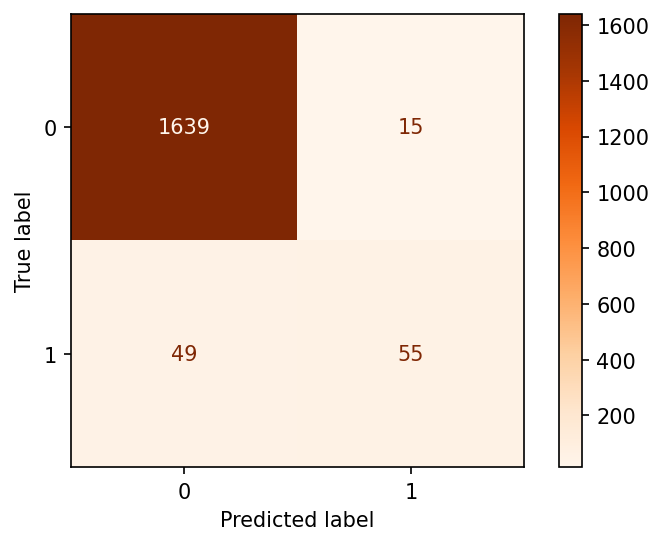

In [7]:
score, class_report, con_matrix = nba_svc(all_data_df, ["PTS/game", "AST/game", "PER", "MP/game", "Age", "All-Star?"], "All-Star next season?", SMOTE=True, print_all=True)

Score on test set (5-fold validation): 0.9579778273062727

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.80      0.53      0.64       104

    accuracy                           0.96      1758
   macro avg       0.88      0.76      0.81      1758
weighted avg       0.96      0.96      0.96      1758




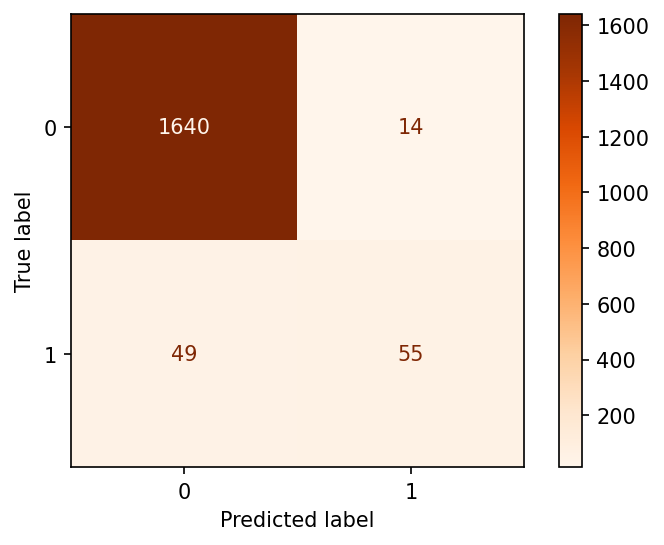

In [8]:
score, class_report, con_matrix = nba_svc(all_data_df, ["PTS/game relative", "AST/game relative", "PER", "MP/game", "Age", "All-Star?"], "All-Star next season?", SMOTE=True, print_all=True)

Score on test set (5-fold validation): 0.9609161293423801

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.79      0.56      0.66       104

    accuracy                           0.97      1758
   macro avg       0.88      0.77      0.82      1758
weighted avg       0.96      0.97      0.96      1758




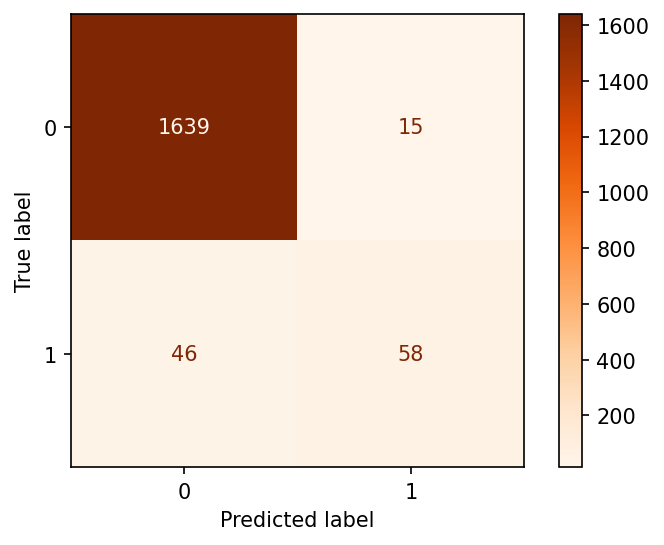

In [13]:
score, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game relative", "AST/game relative", "PER", "MP/game", "Age", "All-Star?"], "All-Star next season?", print_all=True)

Score on test set (5-fold validation): 0.9597216469738039

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.80      0.55      0.65       104

    accuracy                           0.97      1758
   macro avg       0.89      0.77      0.82      1758
weighted avg       0.96      0.97      0.96      1758




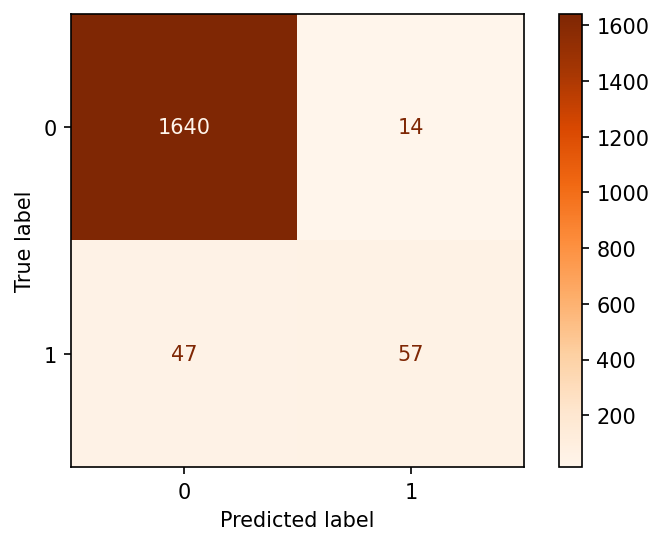

In [15]:
score, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game relative", "AST/game relative", "PER", "MP/game", "Years from prime", "GS", "All-Star?"], "All-Star next season?", print_all=True)

## Trying oversampling and undersampling with a few models

Score on test set (5-fold validation): 0.9611538166133337

Log loss: 1.1788041968479324

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.81      0.56      0.66       104

    accuracy                           0.97      1758
   macro avg       0.89      0.77      0.82      1758
weighted avg       0.96      0.97      0.96      1758




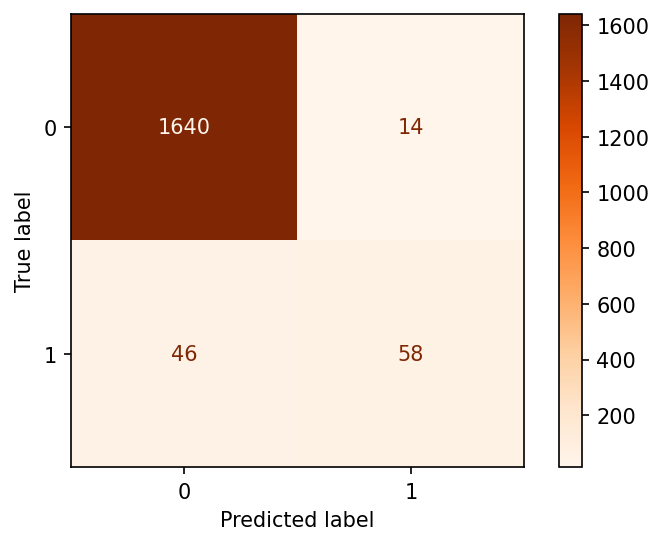

In [5]:
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "PER", "MP/game", "Age", "All-Star?"], "All-Star next season?", RandomOverSampler=True, sample=.8, print_all=True)

Score on test set (5-fold validation): 0.9611538166133337

Log loss: 1.1788041968479324

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.81      0.56      0.66       104

    accuracy                           0.97      1758
   macro avg       0.89      0.77      0.82      1758
weighted avg       0.96      0.97      0.96      1758




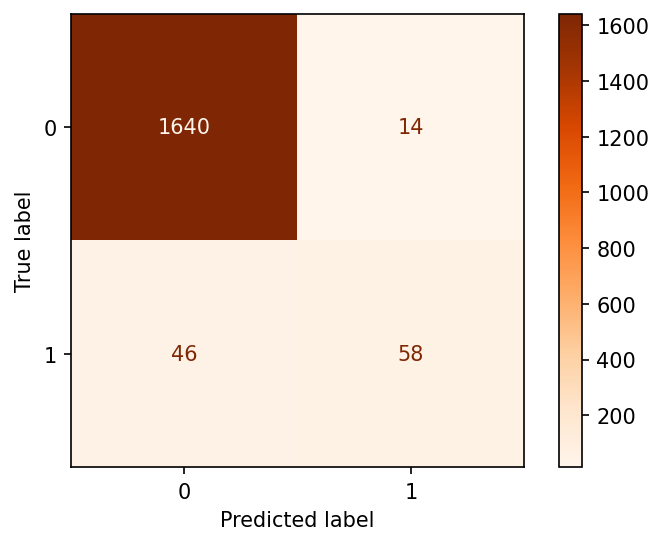

In [7]:
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "PER", "MP/game", "Age", "All-Star?"], "All-Star next season?", RandomUnderSampler=True, print_all=True)

Score on test set (5-fold validation): 0.9611538166133337

Log loss: 1.1788041968479324

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.81      0.56      0.66       104

    accuracy                           0.97      1758
   macro avg       0.89      0.77      0.82      1758
weighted avg       0.96      0.97      0.96      1758




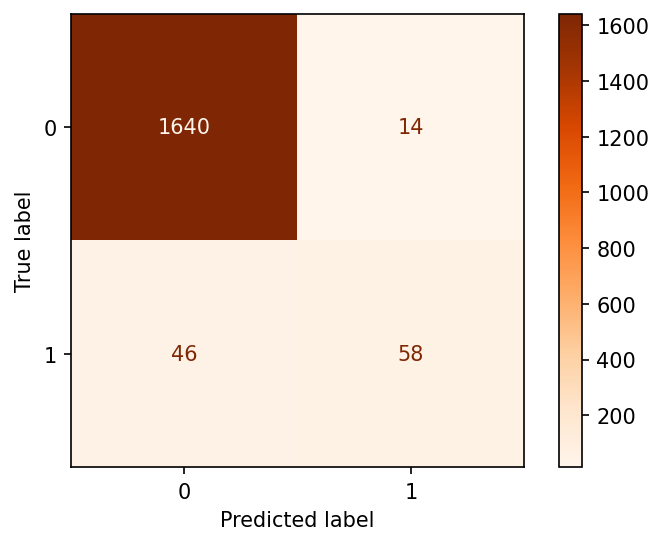

In [8]:
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "PER", "MP/game", "Age", "All-Star?"], "All-Star next season?", print_all=True)

### Neither over- or undersampling added anything to logr model

Score on test set (5-fold validation): 0.9570856159169433

Log loss: 1.237743178639668

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.82      0.51      0.63       104

    accuracy                           0.96      1758
   macro avg       0.89      0.75      0.80      1758
weighted avg       0.96      0.96      0.96      1758




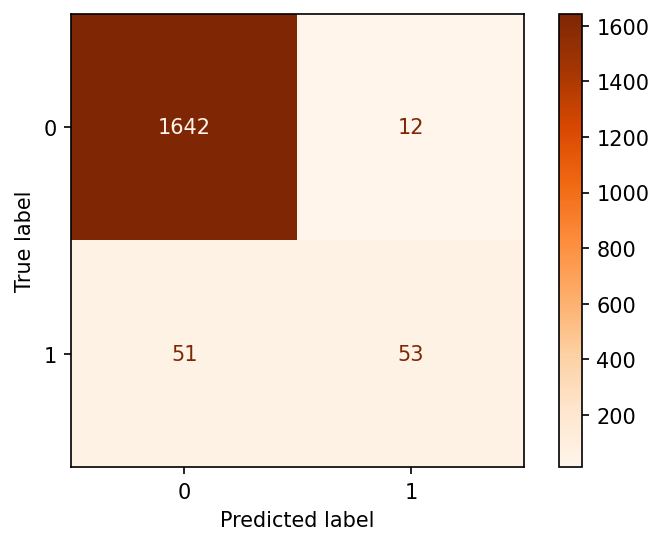

In [9]:
score, logloss, class_report, con_matrix = nba_knn(all_data_df, ["PTS/game", "AST/game", "PER", "MP/game", "Age", "All-Star?"], "All-Star next season?", RandomOverSampler=True, print_all=True)

Score on test set (5-fold validation): 0.9560593209451488

Log loss: 1.2573920832938557

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.77      0.55      0.64       104

    accuracy                           0.96      1758
   macro avg       0.87      0.77      0.81      1758
weighted avg       0.96      0.96      0.96      1758




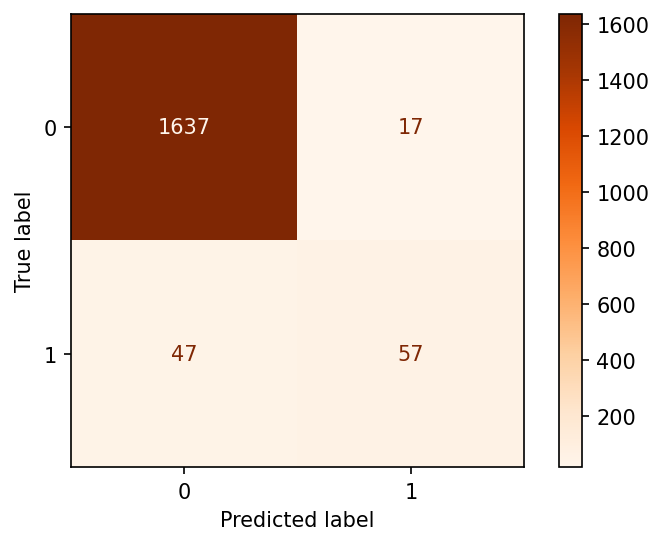

In [12]:
score, logloss, class_report, con_matrix = nba_random_forest(all_data_df, ["PTS/game", "AST/game", "PER", "MP/game", "Age", "All-Star?"], "All-Star next season?", RandomUnderSampler=True, sample=1, print_all=True)

## Bringing in updated_df with "Adjusted TV market value," "Trajectory," etc.

In [13]:
with open("updated_df.pickle", "rb") as to_read:
    all_data_df = pickle.load(to_read)

Score on test set (5-fold validation): 0.9594629106378094

Log loss: 1.218097912654105

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.79      0.55      0.65       104

    accuracy                           0.96      1758
   macro avg       0.88      0.77      0.81      1758
weighted avg       0.96      0.96      0.96      1758




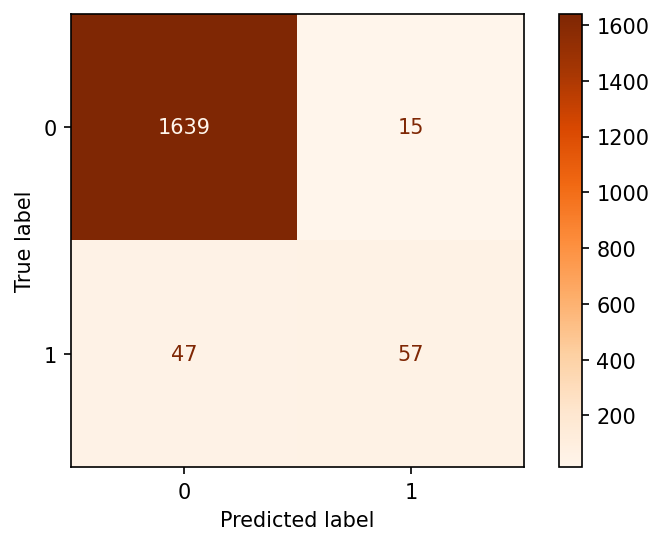

In [15]:
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "PER", "MP/game", "Age", "Adjusted TV market value", "All-Star?"], "All-Star next season?", print_all=True)

Score on test set (5-fold validation): 0.9611538166133337

Log loss: 1.1788041968479324

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.81      0.56      0.66       104

    accuracy                           0.97      1758
   macro avg       0.89      0.77      0.82      1758
weighted avg       0.96      0.97      0.96      1758




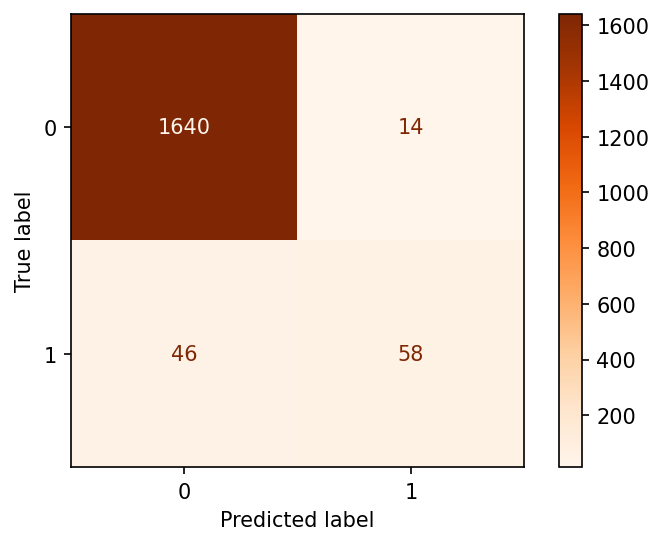

In [16]:
# For comparison
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "PER", "MP/game", "Age", "All-Star?"], "All-Star next season?", print_all=True)

## Adding features one by one to logr model

Score on test set (5-fold validation): 0.9590452863720488

Log loss: 1.3752773242145762

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1654
           1       0.68      0.61      0.64       104

    accuracy                           0.96      1758
   macro avg       0.83      0.79      0.81      1758
weighted avg       0.96      0.96      0.96      1758




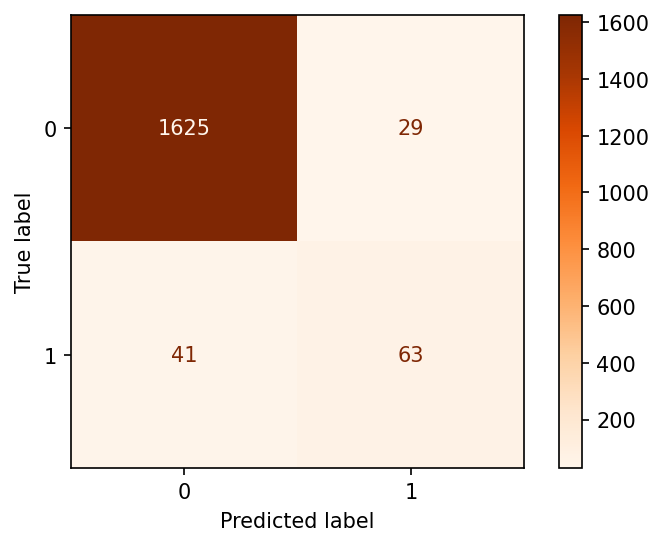

In [29]:
# Just "All-Star?"
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["All-Star?"], "All-Star next season?", print_all=True)

Score on test set (5-fold validation): 0.9552759452294612

Log loss: 1.3949189515315148

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.74      0.49      0.59       104

    accuracy                           0.96      1758
   macro avg       0.85      0.74      0.78      1758
weighted avg       0.96      0.96      0.96      1758




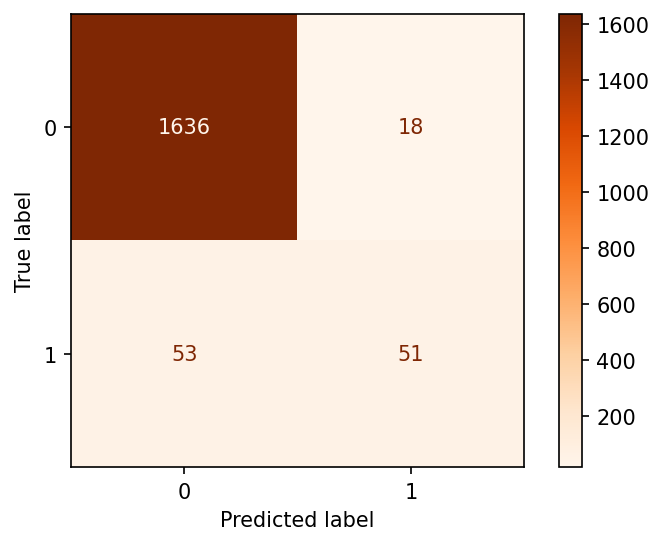

In [32]:
# Adding "PTS/game"
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "All-Star?"], "All-Star next season?", RandomOverSampler=True, print_all=True)

Score on test set (5-fold validation): 0.9553170725086828

Log loss: 1.3949189515315148

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.74      0.49      0.59       104

    accuracy                           0.96      1758
   macro avg       0.85      0.74      0.78      1758
weighted avg       0.96      0.96      0.96      1758




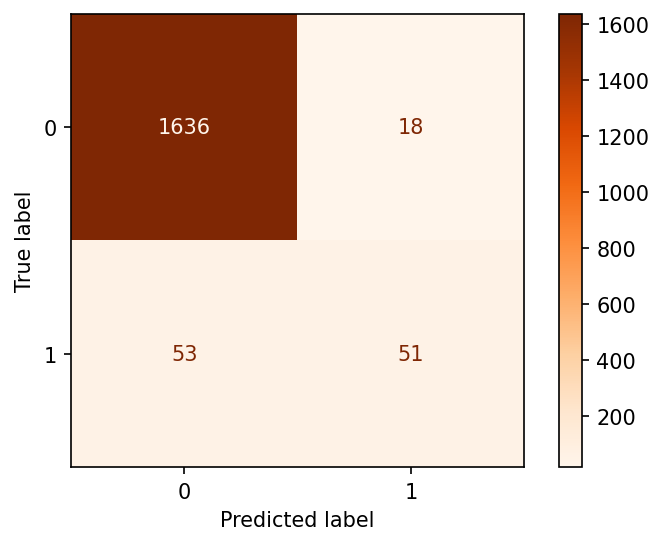

In [35]:
# Swapping "PTS/game" with "PTS/game relative"
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game relative", "All-Star?"], "All-Star next season?", RandomUnderSampler=True, sample=1, print_all=True)

Score on test set (5-fold validation): 0.9562113452284601

Log loss: 1.3163319747527475

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.76      0.52      0.62       104

    accuracy                           0.96      1758
   macro avg       0.87      0.75      0.80      1758
weighted avg       0.96      0.96      0.96      1758




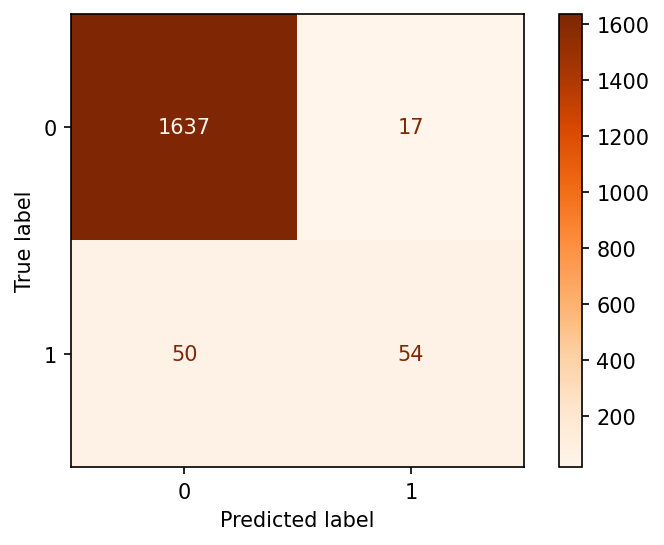

In [38]:
# Adding "AST/game"
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "All-Star?"], "All-Star next season?", print_all=True)

Score on test set (5-fold validation): 0.9578696405670188

Log loss: 1.277038258946575

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.77      0.53      0.63       104

    accuracy                           0.96      1758
   macro avg       0.87      0.76      0.80      1758
weighted avg       0.96      0.96      0.96      1758




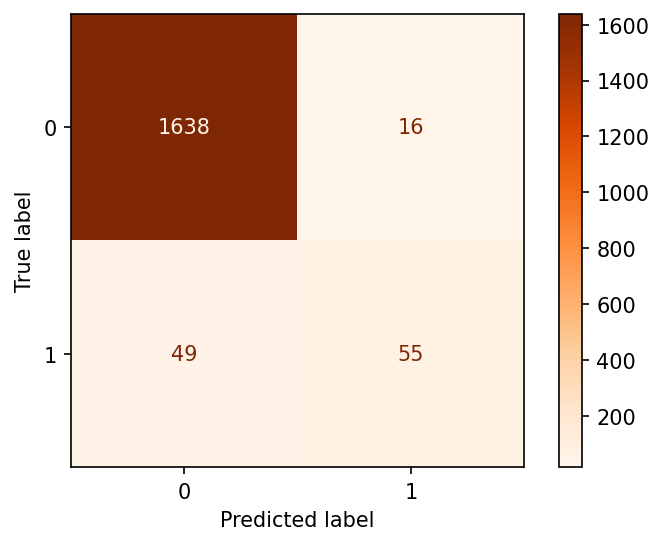

In [41]:
# Adding "Age"
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "Age", "All-Star?"], "All-Star next season?", print_all=True)

Score on test set (5-fold validation): 0.9578696405670188

Log loss: 1.277038258946575

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.77      0.53      0.63       104

    accuracy                           0.96      1758
   macro avg       0.87      0.76      0.80      1758
weighted avg       0.96      0.96      0.96      1758




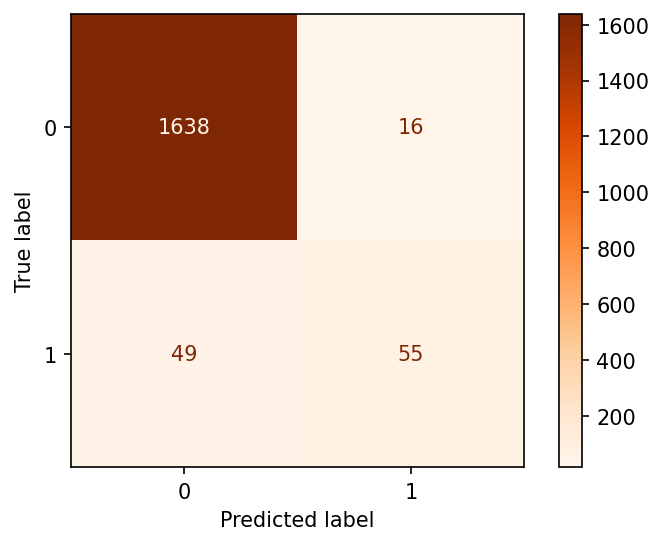

In [43]:
# Adding "Age" and RandomOverSampler=True
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "Age", "All-Star?"], "All-Star next season?", RandomOverSampler=True, sample=1, print_all=True)

Score on test set (5-fold validation): 0.9578696405670188

Log loss: 1.277038258946575

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.77      0.53      0.63       104

    accuracy                           0.96      1758
   macro avg       0.87      0.76      0.80      1758
weighted avg       0.96      0.96      0.96      1758




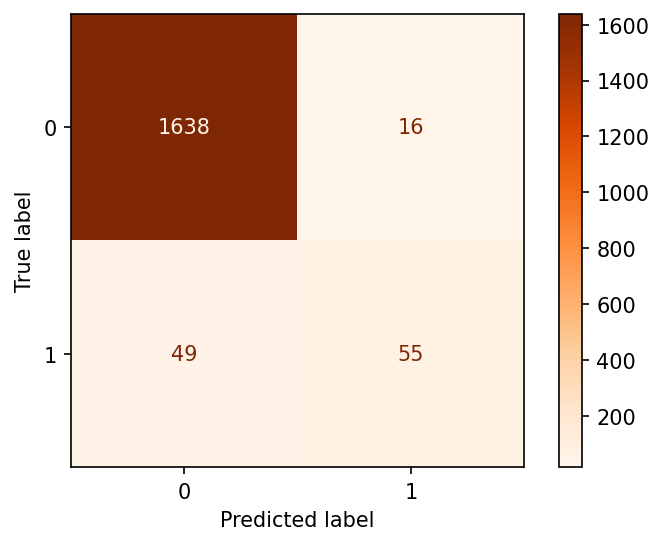

In [45]:
# Adding "Years from prime" instead of "Age"
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "Age", "All-Star?"], "All-Star next season?", RandomOverSampler=True, print_all=True)

Score on test set (5-fold validation): 0.9588207651666891

Log loss: 1.1984508273342298

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.80      0.55      0.65       104

    accuracy                           0.97      1758
   macro avg       0.89      0.77      0.82      1758
weighted avg       0.96      0.97      0.96      1758




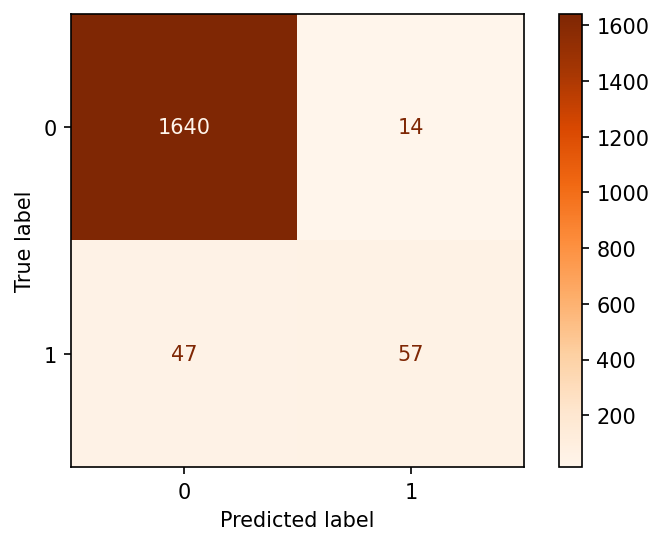

In [49]:
# Adding "PER"
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "Age", "PER", "All-Star?"], "All-Star next season?", print_all=True)

Score on test set (5-fold validation): 0.9588207651666891

Log loss: 1.1984508273342298

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.80      0.55      0.65       104

    accuracy                           0.97      1758
   macro avg       0.89      0.77      0.82      1758
weighted avg       0.96      0.97      0.96      1758




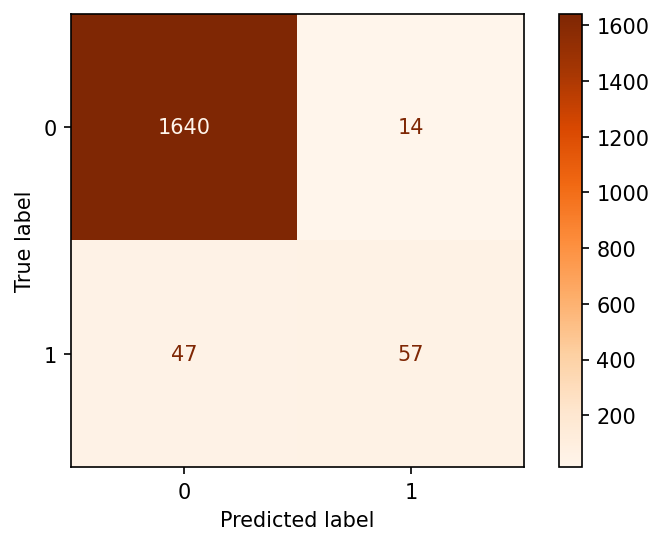

In [51]:
# Adding "PER" and RandomOverSampler=True
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "Age", "PER", "All-Star?"], "All-Star next season?", RandomOverSampler=True, sample=1, print_all=True)

Score on test set (5-fold validation): 0.9611538166133337

Log loss: 1.1788041968479324

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.81      0.56      0.66       104

    accuracy                           0.97      1758
   macro avg       0.89      0.77      0.82      1758
weighted avg       0.96      0.97      0.96      1758




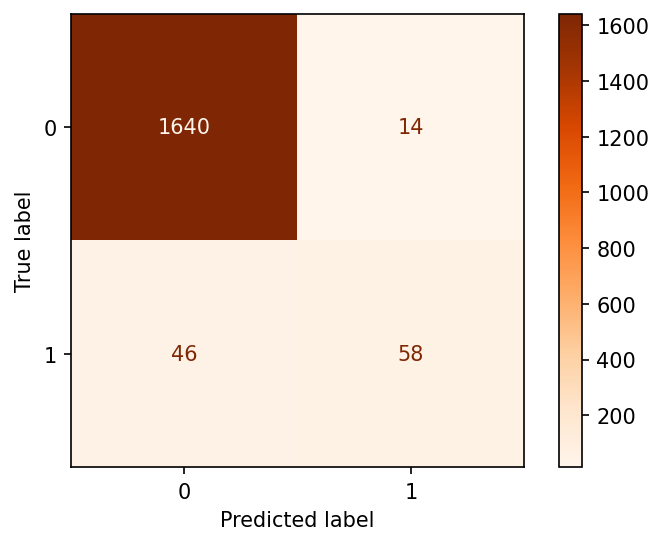

In [52]:
# Adding "MP/game"
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "Age", "PER", "MP/game", "All-Star?"], "All-Star next season?", print_all=True)

Score on test set (5-fold validation): 0.9611538166133337

Log loss: 1.1788041968479324

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.81      0.56      0.66       104

    accuracy                           0.97      1758
   macro avg       0.89      0.77      0.82      1758
weighted avg       0.96      0.97      0.96      1758




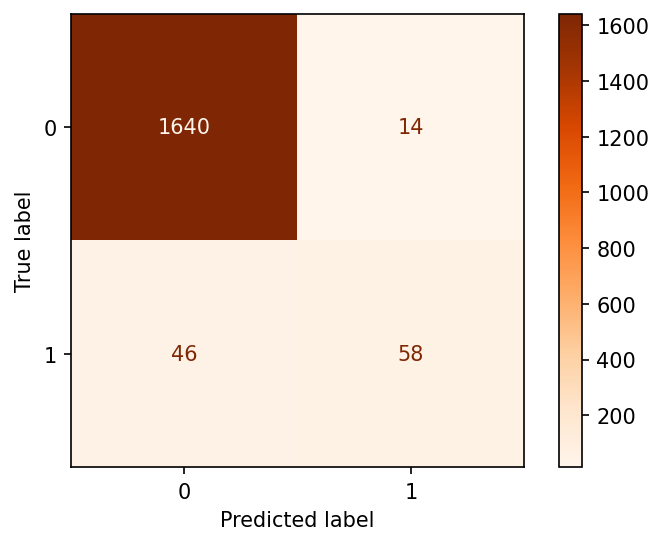

In [54]:
# Adding "MP/game" and RandomOverSampler=True
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "Age", "PER", "MP/game", "All-Star?"], "All-Star next season?", RandomOverSampler=True, sample=1, print_all=True)

Score on test set (5-fold validation): 0.9573134500510837

Log loss: 1.2377445431404024

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1654
           1       0.79      0.54      0.64       104

    accuracy                           0.96      1758
   macro avg       0.88      0.76      0.81      1758
weighted avg       0.96      0.96      0.96      1758




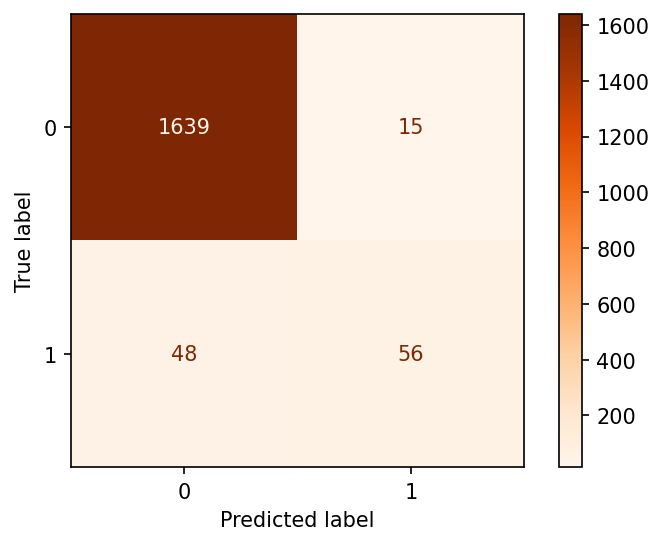

In [56]:
# Adding "GS" instead of "MP/game"
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "Age", "PER", "GS", "All-Star?"], "All-Star next season?", print_all=True)

Score on test set (5-fold validation): 0.9114368057980445

Log loss: 2.0432495705749214

Classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1654
           1       0.00      0.00      0.00       104

    accuracy                           0.94      1758
   macro avg       0.47      0.50      0.48      1758
weighted avg       0.89      0.94      0.91      1758




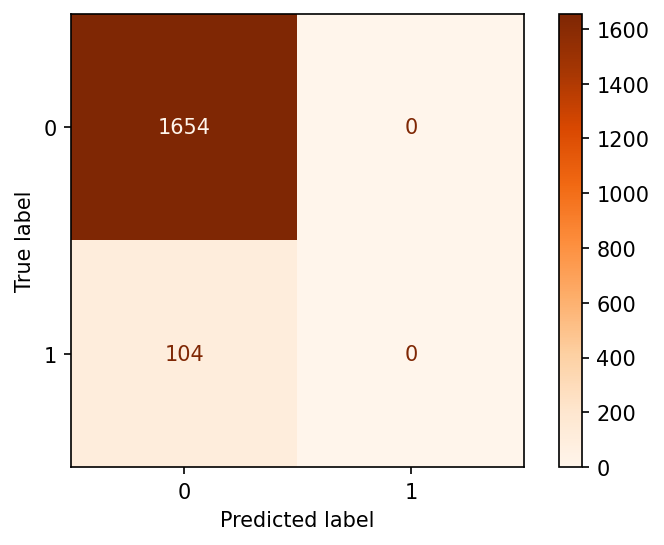

In [19]:
# With "Adjusted TV market value * MP"
score, logloss, class_report, con_matrix = nba_log_regression(all_data_df, ["PTS/game", "AST/game", "PER", "MP/game", "Age", "Adjusted TV market value * MP", "All-Star?"], "All-Star next season?", print_all=True)